In [1]:
import os
os.chdir('..')

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from src.trainer.valid_bar import SilentValidationBar
from src.data_generate.generate_ou import OUDataModule
from src.nn_models.ou_nn_model import LSTMModel
from src.math_methods.mle_ou_params import estimate_params_MLE
from src.math_methods.mm_ou_params import estimate_params_MM

In [3]:
dm = OUDataModule(num_samples=100000, 
                  traj_length=1000,
                  batch_size=64,
                  dt=0.01,
                  theta_range=(0.1, 10.0),
                  mu_range=(-5, 5),
                  sigma_range=(0.1, 5.0),
                  num_workers=16
                 )

In [4]:
model = LSTMModel(

) 

trainer = pl.Trainer(
    max_epochs=25,
    gradient_clip_val=0.5,  
    callbacks=[
        SilentValidationBar(),
        pl.callbacks.LearningRateMonitor(),
        pl.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10,
            mode='min',
            check_on_train_epoch_end=False
        ),
        pl.callbacks.StochasticWeightAveraging(swa_lrs=1e-5)  
    ],
    accelerator='gpu',
    devices=1,
    enable_progress_bar=True,
    accumulate_grad_batches=2 
    
)



trainer.fit(model, datamodule=dm)

# Testing
trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Generating 0/100000 trajectories...
Generating 10000/100000 trajectories...
Generating 20000/100000 trajectories...
Generating 30000/100000 trajectories...
Generating 40000/100000 trajectories...
Generating 50000/100000 trajectories...
Generating 60000/100000 trajectories...
Generating 70000/100000 trajectories...
Generating 80000/100000 trajectories...
Generating 90000/100000 trajectories...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type       | Params
-----------------------------------------
0 | loss_fn   | MSELoss    | 0     
1 | lstm      | LSTM       | 6.8 M 
2 | ln        | LayerNorm  | 1.0 K 
3 | attention | Sequential | 32.9 K
4 | fc        | Sequential | 428 K 
-----------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.201    Total estimated model params size (MB)


Epoch 24: 100%|██████████| 1329/1329 [23:23<00:00,  1.06s/it, loss=0.605, v_num=1, train_loss=0.548, val_loss=0.510]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1329/1329 [23:23<00:00,  1.06s/it, loss=0.605, v_num=1, train_loss=0.548, val_loss=0.510]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 235/235 [01:07<00:00,  3.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5389986634254456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5389986634254456}]

In [92]:
X_test = dm.X_test  
y_test = dm.y_test  

model.eval()  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    test_loader = dm.test_dataloader()
    predictions = []
    for batch in test_loader:
        x_batch, _ = batch
        x_batch = x_batch.to(device)
        batch_preds = model(x_batch)
        predictions.append(batch_preds.cpu())

nn_preds = torch.cat(predictions, dim=0).numpy()
all_true = y_test.numpy()

In [93]:
math_X_test = X_test[:,:,0].numpy()

mle_preds = [] 
mm_preds = []
for i in range(math_X_test.shape[0]):
    mle_preds.append(list(estimate_params_MLE(X=math_X_test[i], dt=0.01)))
    mm_preds.append(list(estimate_params_MM(X=math_X_test[i], dt=0.01)))
mle_preds = np.array(mle_preds)
mm_preds = np.array(mm_preds)

mask = np.isnan(mm_preds) # возникает 1 нан при подсчёте оценок по методу моментов

/home/jovyan/final_project/src/math_methods/mm_ou_params.py:16: RuntimeWarning: invalid value encountered in sqrt
  sigma_hat = np.sqrt(2 * theta_hat * np.var(X))


In [94]:
print(f"MSE on test using Neural Network: {mean_squared_error(all_preds, all_true)}")
print(f"MSE on test using MLE: {mean_squared_error(mle_preds, all_true)}")
print(f"MSE on test using MM: {mean_squared_error(mm_preds[~np.any(mask, axis=1)], all_true[~np.any(mask, axis=1)])}")

MSE on test using Neural Network: 0.5389965176582336
MSE on test using MLE: 1.00609972768531
MSE on test using MM: 0.7008936594031349


In [95]:
def beautiful_print(method:str, all_true: np.array, all_preds:np.array) -> None:
    print(method)
    parameters = ['Theta', 'Mu', 'Sigma']
    stats = []

    for i in range(3):  #
        true_vals = all_true[:, i]
        pred_vals = all_preds[:, i]

        stats.append({
            'parameter': parameters[i],
            'true_mean': np.mean(true_vals),
            'true_std': np.std(true_vals),
            'pred_mean': np.mean(pred_vals),
            'pred_std': np.std(pred_vals)
        })

    print("{:<10} | {:<15} | {:<15} | {:<15} | {:<15}".format(
        "Parameter", "True Mean", "True Std", "Pred Mean", "Pred Std"))
    print("-" * 75)
    for s in stats:
        print("{:<10} | {:<15.4f} | {:<15.4f} | {:<15.4f} | {:<15.4f}".format(
            s['parameter'], 
            s['true_mean'], 
            s['true_std'],
            s['pred_mean'],
            s['pred_std']
        ))
    print(f"MSE on test using {method}: {mean_squared_error(all_preds, all_true)}")

In [96]:
def beautiful_hist(method:str, all_true: np.array, all_preds:np.array) -> None:
    print(method)
    parameters = ['Theta', 'Mu', 'Sigma']
    
    plt.figure(figsize=(15, 10))

    for i, param in enumerate(parameters):
        plt.subplot(2, 2, i+1)  

        true_vals = all_true[:, i]
        pred_vals = all_preds[:, i]

        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        bins = np.linspace(min_val, max_val, 50)

        plt.hist(true_vals, bins=bins, alpha=0.5, label='True', density=True)
        plt.hist(pred_vals, bins=bins, alpha=0.5, label='Predicted', density=True)

        plt.xlabel(param + ' Value')
        plt.ylabel('Density')
        plt.title(f'Distribution of {param}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


NN
Parameter  | True Mean       | True Std        | Pred Mean       | Pred Std       
---------------------------------------------------------------------------
Theta      | 5.0438          | 2.8585          | 4.8960          | 2.6268         
Mu         | -0.0011         | 2.8917          | -0.0422         | 2.8647         
Sigma      | 2.5725          | 1.4113          | 2.5887          | 1.4122         
MSE on test using NN: 0.5389965176582336
NN


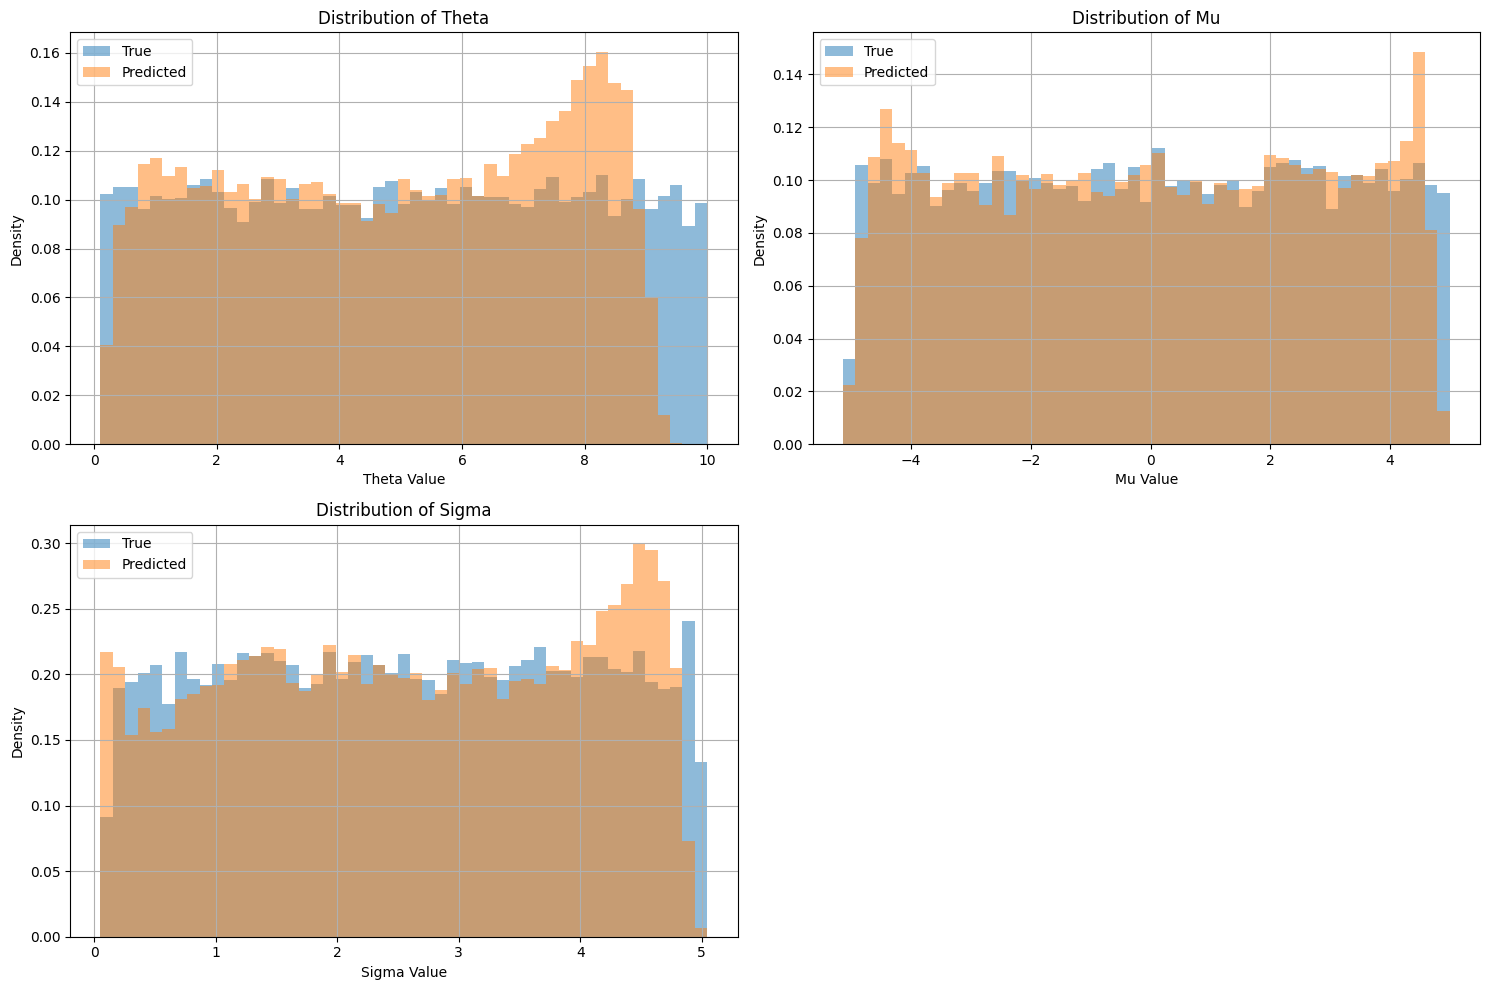

In [98]:
beautiful_print("NN", all_true, nn_preds)
beautiful_hist("NN", all_true, nn_preds)


NN
Parameter  | True Mean       | True Std        | Pred Mean       | Pred Std       
---------------------------------------------------------------------------
Theta      | 5.0438          | 2.8585          | 5.2731          | 3.0949         
Mu         | -0.0011         | 2.8917          | -0.0053         | 3.0258         
Sigma      | 2.5725          | 1.4113          | 2.6407          | 1.4514         
MSE on test using NN: 1.00609972768531
NN


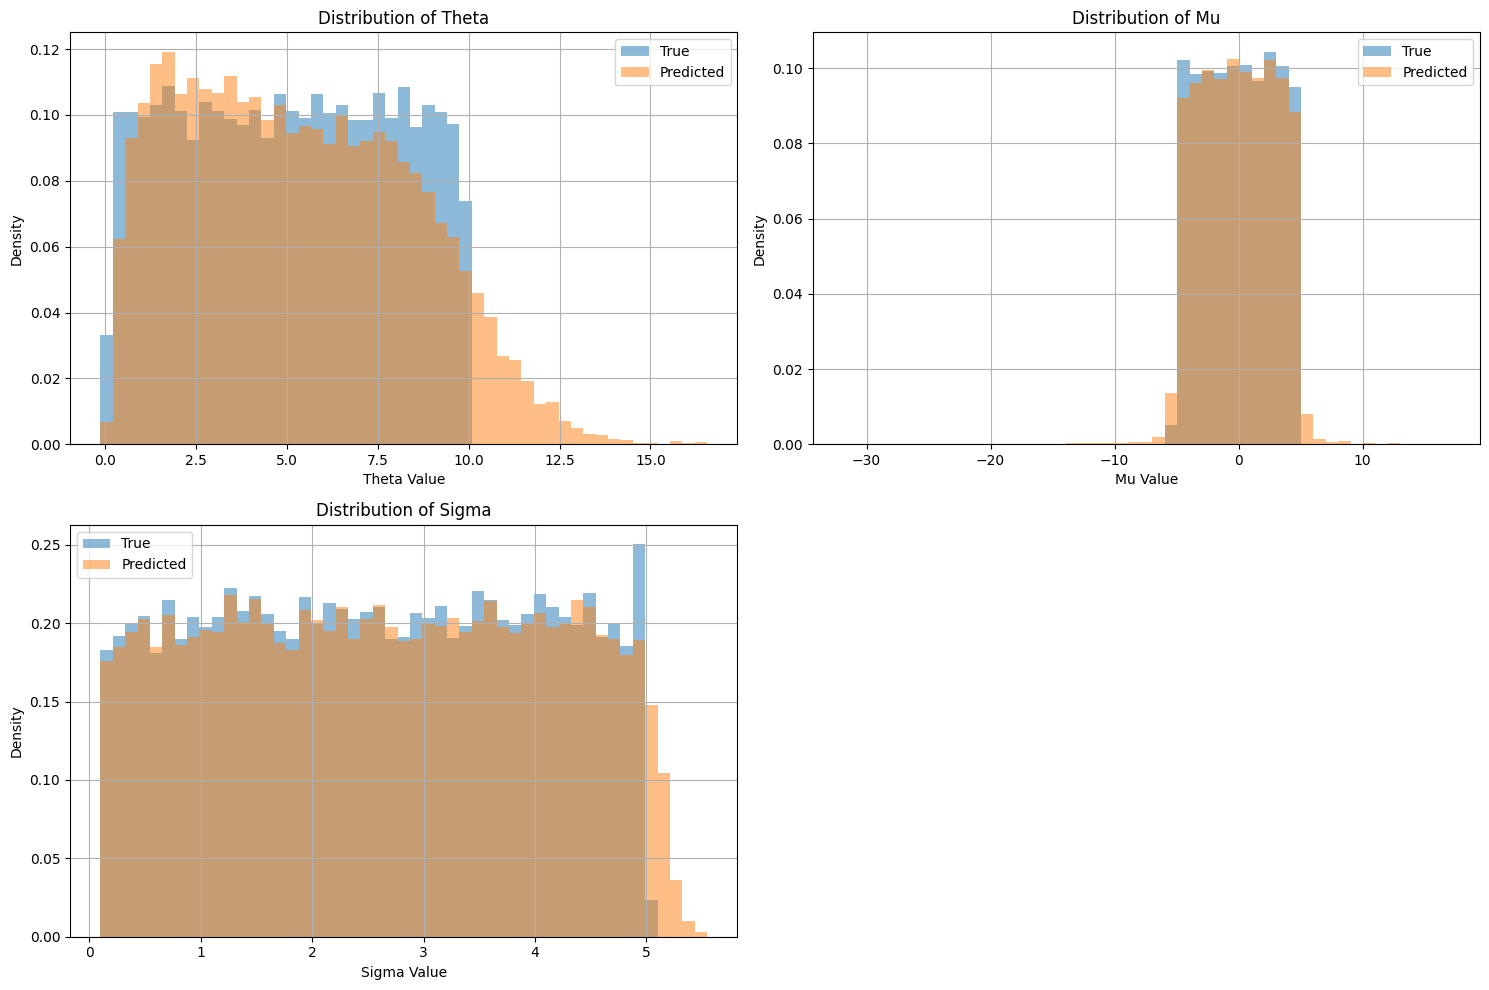

In [100]:
beautiful_print("MLE", all_true, mle_preds)
beautiful_hist("MLE", all_true, mle_preds)

MM
Parameter  | True Mean       | True Std        | Pred Mean       | Pred Std       
---------------------------------------------------------------------------
Theta      | 5.0441          | 2.8583          | 5.5734          | 3.2111         
Mu         | -0.0011         | 2.8918          | -0.0019         | 2.9677         
Sigma      | 2.5725          | 1.4114          | 2.5865          | 1.4257         
MSE on test using MM: 0.7008936594031349
MM


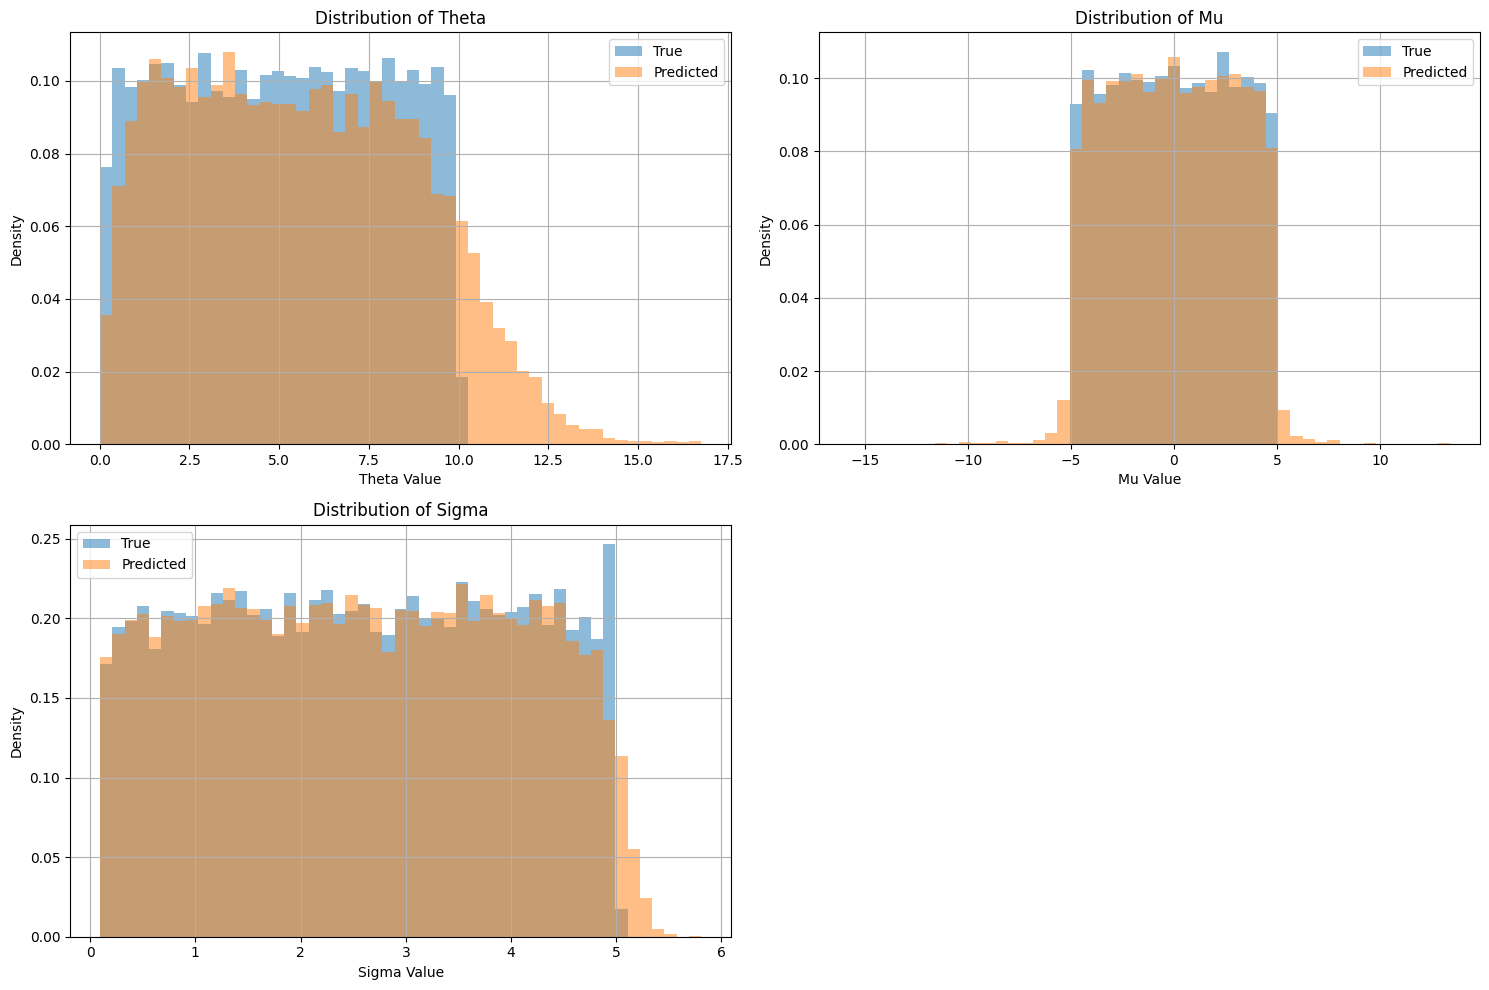

In [101]:
beautiful_print("MM", all_true[~np.any(mask, axis=1)], mm_preds[~np.any(mask, axis=1)])
beautiful_hist("MM", all_true[~np.any(mask, axis=1)], mm_preds[~np.any(mask, axis=1)])

In [102]:
for traj_length in [100, 1000, 5000, 10000]:
    print(f'TRAJ_LENGTH = {traj_length}')
    test_dm = OUDataModule(num_samples=20000, 
                      traj_length=traj_length,
                      batch_size=64,
                      dt=0.01,
                      theta_range=(0.1, 10.0),
                      mu_range=(-5, 5),
                      sigma_range=(0.1, 5.0),
                      num_workers=16
    )

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    test_dm.setup(stage="test")
    test_loader = test_dm.test_dataloader()

    nn_preds = []
    all_true = []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            preds = model(x)

            nn_preds.append(preds.cpu().numpy())
            all_true.append(y.numpy())

    nn_preds = np.concatenate(nn_preds)
    all_true = np.concatenate(all_true)
    beautiful_print("NN", all_true, nn_preds)
      
    math_X_test = test_dm.X_test[:,:,0].numpy()
    mle_preds = [] 
    mm_preds = []
    
    for i in range(math_X_test.shape[0]):
        mle_preds.append(list(estimate_params_MLE(X=math_X_test[i], dt=0.01)))
        mm_preds.append(list(estimate_params_MM(X=math_X_test[i], dt=0.01)))
    mle_preds = np.array(mle_preds)
    mm_preds = np.array(mm_preds)
    mask = np.isnan(mm_preds) # возникает 1 нан при подсчёте оценок по методу моментов
    
    beautiful_print("MLE", all_true, mle_preds)
    beautiful_print("MM", all_true[~np.any(mask, axis=1)], mm_preds[~np.any(mask, axis=1)])

TRAJ_LENGTH = 100
Generating 0/20000 trajectories...
Generating 10000/20000 trajectories...
NN
Parameter  | True Mean       | True Std        | Pred Mean       | Pred Std       
---------------------------------------------------------------------------
Theta      | 5.0155          | 2.8377          | 7.6450          | 1.9921         
Mu         | -0.0041         | 2.8866          | -0.0605         | 2.8117         
Sigma      | 2.5774          | 1.3973          | 3.1574          | 1.1448         
MSE on test using NN: 5.252805233001709


/home/jovyan/final_project/src/math_methods/mm_ou_params.py:16: RuntimeWarning: invalid value encountered in sqrt
  sigma_hat = np.sqrt(2 * theta_hat * np.var(X))


MLE
Parameter  | True Mean       | True Std        | Pred Mean       | Pred Std       
---------------------------------------------------------------------------
Theta      | 5.0155          | 2.8377          | 7.2770          | 5.3200         
Mu         | -0.0041         | 2.8866          | -0.5962         | 28.5571        
Sigma      | 2.5774          | 1.3973          | 2.6434          | 1.4569         
MSE on test using MLE: 279.0452001779551
MM
Parameter  | True Mean       | True Std        | Pred Mean       | Pred Std       
---------------------------------------------------------------------------
Theta      | 5.0230          | 2.8368          | 9.9124          | 6.4016         
Mu         | -0.0079         | 2.8867          | 0.0070          | 2.9559         
Sigma      | 2.5759          | 1.3968          | 2.4973          | 1.4126         
MSE on test using MM: 19.569102814747055
TRAJ_LENGTH = 1000
Generating 0/20000 trajectories...
Generating 10000/20000 trajectories...
NN